In [1]:
#2D simulation of a wave propagating through inhomogeneous medium

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

In [2]:
#user parameters

N=np.array([512, 1024]) # size of grid z,x
u=np.array([0.1, 0.1]) #units z, x in lambda
NA=0.5 #NA of lens
RI=np.array([1.33, 1.4]) #refractive indices of turbid sample (we assume a binary RI-distribution for simplicity)

In [3]:
#creating real-space grid
x=np.arange(-N[1]/2,N[1]/2)*u[1]  #simulation window shows +/- 5 wavelengths in x
z=np.arange(0,N[0])*u[0]  #simulation window shows ~5 wavelengths in z
[X,Z]=np.meshgrid(x,z)

#creating k-space grid
uk=2*np.pi/u/N   #increment in frequency-space is 1/(size of grid in x-space); increment in k-space is 2*pi/(size of grid in x-space)
kx=np.arange(-N[1]/2,N[1]/2)*uk[1] 
kz=np.arange(0,N[0])*uk[0]
[Kx,Kz]=np.meshgrid(kx,kz)

Text(0.5,1,'RI distribution of sample')

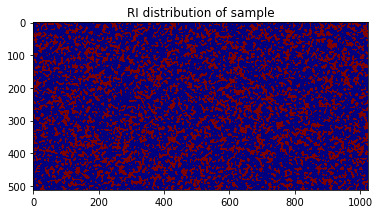

In [4]:
#defining random sample

tmp=np.random.random(N) #array of random numbers with dimensions of N

#low-pass filtering of random sample (performed in k-space)

F_tmp=np.fft.fft2(tmp)  #fourier transform random array
sigma=N/10*u  # 10% of simulation region ~ 5x10 wavelengths in real space
F_filter=np.exp(-X**2/sigma[1]**2-(Z-N[0]*u[0]/2)**2/sigma[0]**2) #Gaussian LP filter function
tmp2=np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(F_filter*F_tmp))) #apply filter, undo shift to center spectrum on zero in k space
                                                                    #2d fft back to lambda space and shift center back to zero
sample=np.fft.ifftshift((tmp2/np.max(tmp2)>0.1)*(RI[1]-RI[0])+RI[0], 1) #undo shift to center on zero for X axis, and threshold normalized values to >0.1
plt.imshow(np.real(sample),cmap='jet')   #Plot real part of filtered random refractive indices
plt.title('RI distribution of sample')


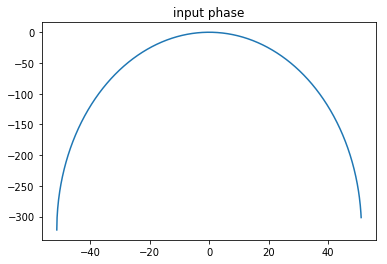

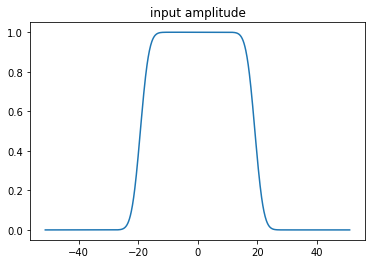

In [5]:
#defining input wavefront: a spherical, converging wave

NA_geo=NA/1.33 #geometric NA of our objective lens

# phase
R=N[0]*u[0] #radius of curvature; define it such that focus lies at last layer
phase = 2*np.pi*(np.sqrt(0j+R**2-x**2)-R)  # spherical phase

# amplitude
amp0=np.abs(x)<R*NA_geo #wave amplitude is 1 for x less than R*NA_geo, didn't know this function of the < operator
sigma_amp=1 #we filter the amplitude a bit to make the edges less sharp
amp_filter=np.exp(-x**2/sigma_amp**2)
F_amp0=np.real(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(amp0))))
amp=np.real(np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(F_amp0*amp_filter))))

plt.figure(1)
plt.plot(x,np.real(phase))
plt.title('input phase')
plt.figure(2)
plt.plot(x,amp)
plt.title('input amplitude')

E=np.zeros(N,dtype='complex') #initializing field 
E_in=np.fft.ifftshift(amp*np.exp(1j*phase))  #already apply ifftshift (loop later is faster)

In [6]:
#defining propagator for each refractive index 

RI=np.unique(sample) 
k = 2 * np.pi * RI/1.33 # k-vectors of light that traverses the different refractive indices, not accounting for objective NA here

prop = np.zeros((len(RI), N[1]), dtype='complex')  # initializing propagators
for q in range(len(RI)):
    prop[q, :] = np.fft.ifftshift(np.exp(1j * u[0] * np.sqrt(0j+k[q] ** 2 - kx ** 2)))

In [8]:
#defining function which propagates the field through the specimen 

def fun_propagate(E_in,sample,prop):
    
    RI=np.unique(sample) #extract different RIs of sample
    N=sample.shape       #size of sample (and field)
    E=np.zeros(N,dtype='complex') #initializing field 
    Ek=np.zeros((len(RI),N[1]),dtype='complex') #init.
    mask=np.zeros((len(RI),N[0],N[1])) #initializing mask
    E[0,:]=E_in 
    
    #constructing binary masks for every RI
    for q in range(len(RI)):
        mask[q,:,:]=sample==RI[q] 
    
    #propagation loop
    for m in range(N[0]-1):
        
        for q in range(len(RI)):
            Ek[q,:]=np.fft.fft(E[m,:]*mask[q,m,:])*prop[q,:]  #for each RI: transform field to k-space and multiply with correct propagator
    
        E[m+1,:]=np.fft.ifft(sum(Ek,0)) #calculate next depth-slice of field
    
    return E

Text(0.5,0,'x')

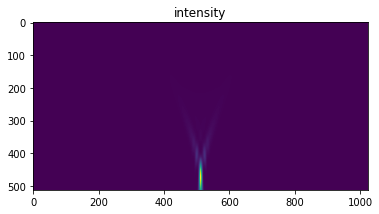

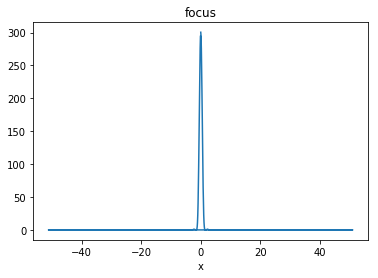

In [101]:
#first we propagate through a homogeneous sample
sample1=1.33*np.ones(N) 

E=fun_propagate(E_in,sample1,prop)   #execute propagation 
    
plt.figure(1)
plt.imshow(np.fft.fftshift(abs(E)**4,1))
plt.title("intensity")

plt.figure(2)
plt.plot(np.fft.fftshift(x),(np.real(E[-1,:])**4))
plt.title('focus')
plt.xlabel('x')

Text(0.5,0,'x')

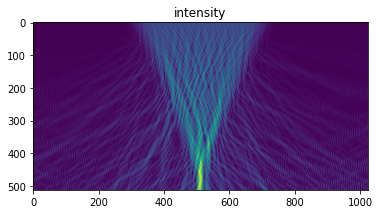

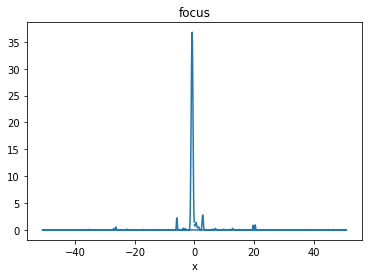

In [100]:
#now we propagate through the turbid sample 

E=fun_propagate(E_in,sample,prop)   #execute propagation 
    
plt.figure(1)
plt.imshow(np.fft.fftshift(abs(E)**1,1))
plt.title("intensity")

plt.figure(2)
plt.plot(np.fft.fftshift(x),(np.real(E[-1,:])**4))
plt.title('focus')
plt.xlabel('x')

In [173]:
def grating1D(spacing, sample):
    "Creates a grating structure with frequency 1/spacing where 'spacing' is in units of wavelength"
    spacing1 = int(spacing/u[1])
    N = sample.shape
    N1 = N[1]*2
    tiles = int(N1/(spacing1*2)) #make grating twice as large as simulated beam window
    remainder = N1 % spacing1
    a = np.zeros(spacing1)
    b = np.ones(spacing1)
    c = np.zeros(remainder)
    unit = np.concatenate((a,b))
    grating = np.concatenate((np.tile(unit, tiles), c))
  
    return grating

In [182]:
def step_beam(sample, grating_spacing, beam_step):
    '''Steps beam propagated through 'sample' across grating with spacing 'grating_spacing' with a step size 'beam_step' in units of wavelength.''' 
    grating = grating1D(grating_spacing, sample) #create sample grating with spacing grating_spacing in units of wavelength
    plt.figure(1)
    plt.plot(grating)
    plt.title('grating structure')
    plt.xlabel('x')
    N = sample.shape
    E = fun_propagate(E_in,sample,prop)  #calculate electric field at focus modulated by sample
    beam = abs(E[-1,:])**4   #Electric field from earlier calculation raised to 4th power 
    m = int(beam_step/u[1])  #size of steps during beam scan
    num_steps = int(N[1]/m) #number of steps in image
    lines = np.zeros((num_steps, N[1]*2)) #make array to hold each line of the scan 
    for q in range(num_steps):  #loop to step beam and add up intensities
        a = np.zeros(m*q)
        b = np.zeros(1024 - m*q)
        beam_padded = np.concatenate((a, np.fft.fftshift(beam/np.max(beam)), b))
        lines[q,:] = beam_padded * grating
    image = np.sum(lines, axis = 0)
    return image

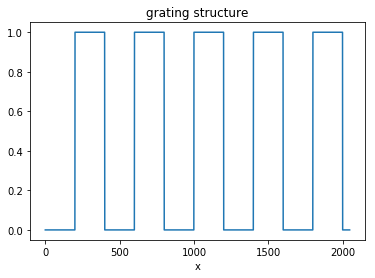

In [201]:
test = step_beam(sample, 20, 0.1)

(59.8, 60.1)

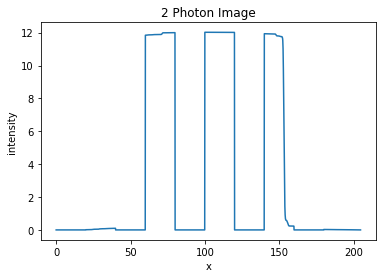

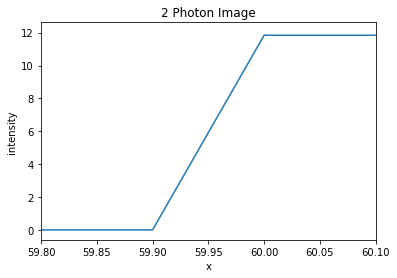

In [204]:
xnew = np.arange(0, 204.8, 0.1)
plt.figure(1)
plt.plot(xnew, test)
plt.title('2 Photon Image')
plt.xlabel('x')
plt.ylabel('intensity')

plt.figure(2)
plt.plot(xnew, test)
plt.title('2 Photon Image')
plt.xlabel('x')
plt.ylabel('intensity')
plt.xlim([59.8, 60.1])